In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import codecs
from torch.utils.data import Dataset
import torch
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DataPreprocessing**

In [ ]:
def Preprocess_data():
  data_fixed = pd.read_csv('/content/drive/MyDrive/Emotion/data/Fixed Text Typing Dataset.csv', sep=';',low_memory=False,dtype=str)
  data_fixed=data_fixed.drop(columns=['answer'])
  for col in ['keyDown', 'keyUp','userId']:

      data_fixed[col] = data_fixed[col].astype(str).str.replace(',', '.').astype(float)
  for col in ['D1U1','D1U2','U1U2','D1D2','U1D2','D1U3','D1D3']:
      data_fixed[col] = data_fixed[col].astype(str).str.replace(',', '.').astype(float)
  # Liste des userId à exclure
  user_ids_to_exclude = [83, 171,104,86]
  df_filtered = data_fixed[~data_fixed['userId'].isin(user_ids_to_exclude)]
  df_clean = df_filtered.dropna()
  valeurs_exclues = [1.58e12, -1.58e12]
  df_final = df_clean[~df_clean['D1U1'].isin(valeurs_exclues)]
  df_final = df_final[~df_final['D1U2'].isin(valeurs_exclues)]
  df_final = df_final[~df_final['U1U2'].isin(valeurs_exclues)]
  df_final = df_final[~df_final['U1D2'].isin(valeurs_exclues)]
  df_final = df_final[~df_final['D1D2'].isin(valeurs_exclues)]
  df_final = df_final[~df_final['D1U3'].isin(valeurs_exclues)]
  df_final = df_final[~df_final['D1D3'].isin(valeurs_exclues)]
  df_final = df_final.dropna()
  cols = ['D1U1','D1U2','U1U2','D1D2','U1D2','D1U3','D1D3']
  z_scores = df_final[cols].apply(zscore)
  threshold = 3
  df_no_outliers = df_final[(z_scores.abs() <= threshold).all(axis=1)]
  i=0
  users=[100,120,113,93,130,131,49,161,29,41,68,72,56,123,58,63,84,174,139,147,110,47,95,87,141,106,121,181,135,155,70,48,170,65,35,98,126,136,94,97,82,67,40,77,73,150,25,112,101,99,13,108,167,168,31,128,144,118,109]
  current_df = df_no_outliers
  for u in users:
    i=i+1
    new_df_name ="df"+str(i)
    filtered_df = current_df[~((current_df['emotionIndex']=='N')&(current_df['userId']==u))]
    globals()[new_df_name] = filtered_df
    current_df = filtered_df

  def parse_ascii_code(x):
    try:
        if pd.isnull(x):
            return None
        if isinstance(x, str) and len(x) > 1 and x.startswith('\\'):
            # Convertir chaîne comme '\\b' en vrai caractère \b
            real_char = codecs.decode(x, 'unicode_escape')
            if len(real_char) == 1:
                return ord(real_char)
            else:
                return None
        elif len(x) == 1:
            return ord(x)
        return None
    except:
        return None
  current_df['ascii_code'] = current_df['keyCode'].apply(parse_ascii_code)
  current_df.reset_index(drop=True, inplace=True) # Reset index after filtering
  return current_df

In [ ]:

import pandas as pd

def rename_repeated_users(current_df, start_new_id=500):
    df = current_df.copy()

    users_per_emotion = {}
    new_user_id = start_new_id

    current_user = None
    current_emotion = None

    for idx, row in df.iterrows():
        user = row["userId"]
        emotion = row["emotionIndex"]

        if (user != current_user) or (emotion != current_emotion):
            if current_user is not None:
                if current_emotion not in users_per_emotion:
                    users_per_emotion[current_emotion] = []
                if current_user not in users_per_emotion[current_emotion]:
                    users_per_emotion[current_emotion].append(current_user)

            if emotion not in users_per_emotion:
                users_per_emotion[emotion] = []

            if user in users_per_emotion[emotion]:
                new_user_id += 1
                j = idx
                while j < len(df) and df.loc[j, "userId"] == user and df.loc[j, "emotionIndex"] == emotion:
                    df.at[j, "userId"] = new_user_id
                    j += 1

            current_user = user
            current_emotion = emotion

    # Ajouter le dernier couple
    if current_user is not None:
        if current_emotion not in users_per_emotion:
            users_per_emotion[current_emotion] = []
        if current_user not in users_per_emotion[current_emotion]:
            users_per_emotion[current_emotion].append(current_user)

    return df, users_per_emotion

In [ ]:
# ------------------------------
# Étape 1 : Collecter 150 lignes par user/emotion
# ------------------------------
def collect_fixed_length_sequences(df, features_cols, seq_len_fixed=100):
    sequences_per_user = []
    labels_per_user = []
    emotions = ['A','H','S','C']
    label_to_idx = {emotion: idx for idx, emotion in enumerate(emotions)}

    for emotion in emotions:
        emotion_df = df[df['emotionIndex'] == emotion]
        for user_id in emotion_df['userId'].unique():
            user_df = emotion_df[emotion_df['userId'] == user_id]
            features = user_df[features_cols].values.astype(np.float32)

            if len(features) < seq_len_fixed:
                pad_len = seq_len_fixed - len(features)
                pad = np.zeros((pad_len, features.shape[1]), dtype=np.float32)
                features = np.vstack([features, pad])
            else:
                features = features[:seq_len_fixed]

            sequences_per_user.append(torch.tensor(features, dtype=torch.float32))
            labels_per_user.append(label_to_idx[emotion])

    return sequences_per_user, labels_per_user, label_to_idx

# ------------------------------
# Étape 2 : Sliding window sur chaque partition
# ------------------------------
def sliding_window_sequences(sequences_150, labels, seq_len, stride):
    X_list, y_list = [], []
    for seq_150, label in zip(sequences_150, labels):
        for start in range(0, seq_150.shape[0] - seq_len + 1, stride):
            window = seq_150[start:start+seq_len]

            zero_lines = (window.abs().sum(dim=1) == 0).sum().item()
            if zero_lines > 1:
                continue

            X_list.append(window)
            y_list.append(label)
    return X_list, y_list

In [ ]:
def standardize_sequences(X_list, means, stds):
    means = torch.tensor(means, dtype=torch.float32)
    stds = torch.tensor(stds, dtype=torch.float32)

    stds[stds == 0] = 1.0

    X_list_standardized = []
    for seq in X_list:
        standardized = (seq - means) / stds
        X_list_standardized.append(standardized)

    return X_list_standardized

In [ ]:
def compute_standardization_stats(X_data):
    all_data = []
    for seq in X_data:
        all_data.append(seq)  # chaque seq : (50, nb_features)
    all_data = np.concatenate(all_data, axis=0)  # → (N, nb_features)
    mean = all_data.mean(axis=0)
    std = all_data.std(axis=0)
    std[std == 0] = 1.0
    return mean, std

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
import random

def split_users_global(users_per_emotion, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    random.seed(seed)

    # 1. Récupérer tous les users uniques (sur toutes émotions)
    all_users = set()
    for users in users_per_emotion.values():
        all_users.update(users)
    all_users = list(all_users)

    # 2. Shuffle pour mélanger
    random.shuffle(all_users)

    # 3. Découper en train / val / test
    n = len(all_users)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)

    train_users = set(all_users[:n_train])
    test_users = set(all_users[n_train:n_train+n_val])
    val_users  = set(all_users[n_train+n_val:])

    return train_users, val_users, test_users


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# ============================================================
# 2. Data Augmentation
# ============================================================
def add_noise_multi(X_list, y_list, levels_noise=[0.05,0.01,0.08]):
    """
    Génère plusieurs versions bruitées de X_list selon des niveaux de bruit.

    Args:
        X_list (list): Liste de tensors ou arrays (chaque tensor: [seq_len, nb_features])
        y_list (list/array): Labels correspondants
        noise_levels (list): Liste des niveaux de bruit à appliquer

    Returns:
        X_aug, y_aug : numpy arrays / tensors concaténés
    """
    X_aug, y_aug = list(X_list), list(y_list)
    for noise in levels_noise:
        # Générer un bruit pour chaque séquence
        for seq, label in zip(X_list, y_list):
                if not isinstance(seq, torch.Tensor):
                    seq = torch.tensor(seq, dtype=torch.float32)
                # Bruit proportionnel à l'écart type de la séquence
                seq_noisy = seq + torch.randn_like(seq) * noise * seq.std()
                X_aug.append(seq_noisy)
                y_aug.append(label)

    return X_aug, y_aug

In [ ]:
from collections import Counter
import random

def balance_classes(X, y, seed=42):
    random.seed(seed)

    # Compter le nombre d'exemples par classe
    counter = Counter(y)
    min_count = min(counter.values())  # taille minimale de classe

    X_bal, y_bal = [], []
    for cls in counter.keys():
        indices = [i for i, lbl in enumerate(y) if lbl == cls]
        sampled_indices = random.sample(indices, min_count)

        for idx in sampled_indices:
            X_bal.append(X[idx])
            y_bal.append(y[idx])

    return X_bal, y_bal


# **Data Preparation**

In [ ]:
current_df=Preprocess_data()

/tmp/ipython-input-1476784189.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['ascii_code'] = current_df['keyCode'].apply(parse_ascii_code)


In [ ]:
current_df, users_per_emotion = rename_repeated_users(current_df)

**balance number of users**

In [ ]:
i=0
users=[100,120,113,93,56,123,58,63,141,106,121,181,135,155,70,48,41]
for u in users:
    i=i+1
    # Create the name for the new dataframe
    new_df_name ="df"+str(i)
    # Filter the current dataframe
    filtered_df = current_df[~((current_df['emotionIndex']=='C')&(current_df['userId']==u))]
    globals()[new_df_name] = filtered_df
    # Update current_df for the next iteration
    current_df = filtered_df

In [ ]:
i=0
users=[100,120,113,93,56,123,58,63,141,106,121,181,135,155,70]
for u in users:
    i=i+1
    # Create the name for the new dataframe
    new_df_name ="df"+str(i)
    # Filter the current dataframe
    filtered_df = current_df[~((current_df['emotionIndex']=='S')&(current_df['userId']==u))]
    globals()[new_df_name] = filtered_df
    # Update current_df for the next iteration
    current_df = filtered_df

In [ ]:
i=0
users=[100,120,113,93,56,123,58,63,141,106,121,181,135,155,70,48,101,99,13,108,35,98,126,136,94, 139.0,110.0]
for u in users:
    i=i+1
    # Create the name for the new dataframe
    new_df_name ="df"+str(i)
    # Filter the current dataframe
    filtered_df = current_df[~((current_df['emotionIndex']=='H')&(current_df['userId']==u))]
    globals()[new_df_name] = filtered_df
    # Update current_df for the next iteration
    current_df = filtered_df

In [ ]:
current_df, users_per_emotion = rename_repeated_users(current_df)

In [ ]:
len(users_per_emotion['A'])

23

In [ ]:
len(users_per_emotion['C'])

23

In [ ]:
len(users_per_emotion['S'])

23

In [ ]:
len(users_per_emotion['H'])

23

In [ ]:
df, users_per_emotion = rename_repeated_users(current_df)
train_users, val_users, test_users = split_users_global(users_per_emotion)
df_train = df[df["userId"].isin(train_users)]
df_val   = df[df["userId"].isin(val_users)]
df_test  = df[df["userId"].isin(test_users)]

In [ ]:
df_train['userId'].unique()

array([113.,  58.,  84.,  95., 130., 122., 170., 501.,  40.,  25., 101.,
       502., 167.,  31., 144., 131.,  94., 109.,  55.,  67., 117., 110.,
       503.,  79.,  44., 127.,  87., 142., 504.,  52.,  19.,  49., 148.,
       147.,  97.,  89.,  76.,  73., 115., 193., 114., 118., 128., 108.,
       506.,  99., 100., 103., 112.,  77., 507.,  35.,  48.,  93., 508.,
       509.,  47., 174.,  41.])

In [ ]:
df_val['userId'].unique()

array([164., 133.,  61.,  53., 150., 155.,  29.,  72.])

In [ ]:
df_test['userId'].unique()

array([138., 505., 106., 136.,  65., 510., 511.])

# **Prepare Data**

In [ ]:
def prepare_dataloaders(df_train, df_val, df_test, feature_cols,
                        seq_len=30, stride=1, batch_size=32, augment=False):
    # --- Étape 1 : collecter séquences fixes ---
    x_train, y_train, label_to_idx = collect_fixed_length_sequences(df_train, feature_cols)
    x_val, y_val, _ = collect_fixed_length_sequences(df_val, feature_cols)
    x_test, y_test, _ = collect_fixed_length_sequences(df_test, feature_cols)

    # --- Étape 2 : sliding window ---
    X_train, y_train = sliding_window_sequences(x_train, y_train, seq_len, stride)
    X_val, y_val     = sliding_window_sequences(x_val, y_val, seq_len, stride)
    X_test, y_test   = sliding_window_sequences(x_test, y_test, seq_len, stride)

    # --- Data augmentation sur train uniquement ---
    if augment:
        X_train,y_train = add_noise_multi(X_train,y_train)

    # --- Étape 3 : Standardisation globale (train only) ---
    means, stds = compute_standardization_stats(X_train)
    X_train = standardize_sequences(X_train, means, stds)
    X_val   = standardize_sequences(X_val, means, stds)
    X_test  = standardize_sequences(X_test, means, stds)

    # --- Étape 4 : création des datasets ---
    train_dataset = EmotionDataset(X_train, y_train)
    val_dataset   = EmotionDataset(X_val, y_val)
    test_dataset  = EmotionDataset(X_test, y_test)

    # --- Étape 5 : dataloaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
    return means,stds,y_train,y_val,y_test,train_loader, val_loader, test_loader, label_to_idx

In [ ]:
features_cols = ['D1U1','D1U2','U1U2','D1D2','U1D2','D1U3']

means,stds,y_train,y_val,y_test,train_loader, val_loader, test_loader, label_to_idx = prepare_dataloaders(
    df_train, df_val, df_test,
    feature_cols=features_cols,
    seq_len=65,
    stride=20,
    batch_size=32,
    augment=True  # active bruit sur train
)

Train: 560 | Val: 24 | Test: 20


In [ ]:
means

array([100.53652, 439.7143 , 339.35602, 337.61746, 237.0325 , 777.6308 ],
      dtype=float32)

In [ ]:
stds

array([ 42.839725, 365.99536 , 368.1581  , 363.02792 , 366.84238 ,
       552.35223 ], dtype=float32)

In [ ]:
from collections import Counter

counts = Counter(y_train)
print(counts)

Counter({1: 152, 3: 152, 2: 136, 0: 120})


In [ ]:
from collections import Counter

counts = Counter(y_val)
print(counts)

Counter({0: 10, 2: 6, 1: 4, 3: 4})


In [ ]:
from collections import Counter

counts = Counter(y_test)
print(counts)

Counter({0: 6, 2: 6, 1: 4, 3: 4})


#**Transformer Model**

In [ ]:
from torch import nn
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, k, d_model, seq_len):
        super().__init__()

        self.embedding = nn.Parameter(torch.zeros([k,d_model], dtype=torch.float), requires_grad=True)
        nn.init.xavier_uniform_(self.embedding, gain=1)
        self.positions = torch.tensor([i for i in range(seq_len)], requires_grad=False).unsqueeze(1).repeat(1, k)
        s = 0.0
        interval = seq_len / k
        mu = []
        for _ in range(k):
            mu.append(nn.Parameter(torch.tensor(s, dtype=torch.float), requires_grad=True))
            s = s + interval
        self.mu = nn.Parameter(torch.tensor(mu, dtype=torch.float).unsqueeze(0), requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor([torch.tensor([50.0], dtype=torch.float, requires_grad=True) for _ in range(k)]).unsqueeze(0))

    def normal_pdf(self, pos, mu, sigma):
        mu = mu.to(device)
        sigma = sigma.to(device)
        pos = pos.to(device)
        a = pos - mu
        log_p = -1*torch.mul(a, a)/(2*(sigma**2)) - torch.log(sigma)
        return torch.nn.functional.softmax(log_p, dim=1)

    def forward(self, inputs):
        pdfs = self.normal_pdf(self.positions, self.mu, self.sigma)
        pos_enc = torch.matmul(pdfs, self.embedding)
        return inputs + pos_enc.unsqueeze(0).repeat(inputs.size(0), 1, 1)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, heads, _heads, dropout,seq_len):
        super(TransformerEncoderLayer, self).__init__()

        self.attention = nn.MultiheadAttention(d_model, heads, batch_first=True)
        self._attention = nn.MultiheadAttention(seq_len, _heads, batch_first=True)

        self.attn_norm = nn.LayerNorm(d_model)

        self.cnn_units = seq_len

        self.cnn = nn.Sequential(
            nn.Conv2d(1, self.cnn_units, (1, 1), stride=1),
            nn.BatchNorm2d(self.cnn_units),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(self.cnn_units, self.cnn_units, (3, 3), padding=1),
            nn.BatchNorm2d(self.cnn_units),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv2d(self.cnn_units, 1, (5, 5), padding=2),
            nn.BatchNorm2d(1),
            nn.Dropout(dropout),
            nn.ReLU()
        )

        self.final_norm = nn.LayerNorm(d_model)

    def forward(self, src):
        src = self.attn_norm(src + self.attention(src, src, src)[0] + self._attention(src.transpose(-1, -2), src.transpose(-1, -2), src.transpose(-1, -2))[0].transpose(-1, -2))
        src = self.final_norm(src + self.cnn(src.unsqueeze(dim=1)).squeeze(dim=1))

        return src

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, heads, _heads, seq_len, num_layer=2, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(num_layer):
            self.layers.append(TransformerEncoderLayer(d_model, heads, _heads, dropout, seq_len))

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)

        return src

class ClassificationKeystrokeModel(nn.Module):
    def __init__(self, num_layer, d_model, k, heads, _heads, seq_len, num_classes, inner_dropout):
        super(ClassificationKeystrokeModel, self).__init__()

        self.pos_encoding = PositionalEncoding(k, d_model, seq_len)
        self.encoder = TransformerEncoder(d_model, heads, _heads, seq_len, num_layer, inner_dropout)

        self.ff = nn.Sequential(
            nn.Linear(seq_len * d_model, 512),
            nn.ReLU(),
            nn.Dropout(inner_dropout),
            nn.Linear(512, num_classes)  # num_classes = nombre d'émotions ou classes
        )


    def forward(self, inputs):
        encoded_inputs = self.pos_encoding(inputs)
        enc_out = self.encoder(encoded_inputs)
        flattened = torch.flatten(enc_out, start_dim=1, end_dim=2)  # Flatten to [batch_size, seq_len * d_model]
        logits = self.ff(flattened)  # [batch_size, num_classes]
        return logits

# **Model Traning**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch import nn
import torch
from torch.optim import Adam

model = ClassificationKeystrokeModel(
    num_layer=1,
    d_model=6,
    k=32,
    heads=3,
    _heads=5,
    seq_len=65,
    num_classes=4,
    inner_dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

**Trainig**

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Mettre le modèle sur le bon device
model.to(device)

# Hyperparamètres
epochs = 150
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Historique
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # ----- Entraînement -----
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ----- Validation -----
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            logits = model(X_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == y_val).sum().item()
            val_total += y_val.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Restaurer le meilleur modèle
model.load_state_dict(best_model_state)

# 🎨 Courbes Loss & Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

**Testing**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.80      1.00      0.89         4
           2       0.80      0.67      0.73         6
           3       0.75      0.75      0.75         4

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.84        20
weighted avg       0.85      0.85      0.85        20



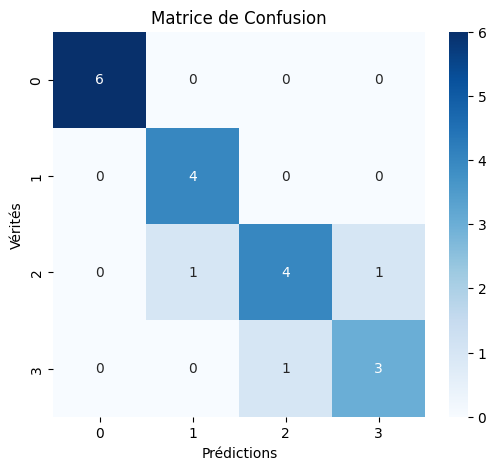

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds))

# Confusion matrix (brute)
cm = confusion_matrix(all_labels, all_preds)
# Affichage graphique de la matrice de confusion
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
torch.save(model.state_dict(), "Model.pth")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


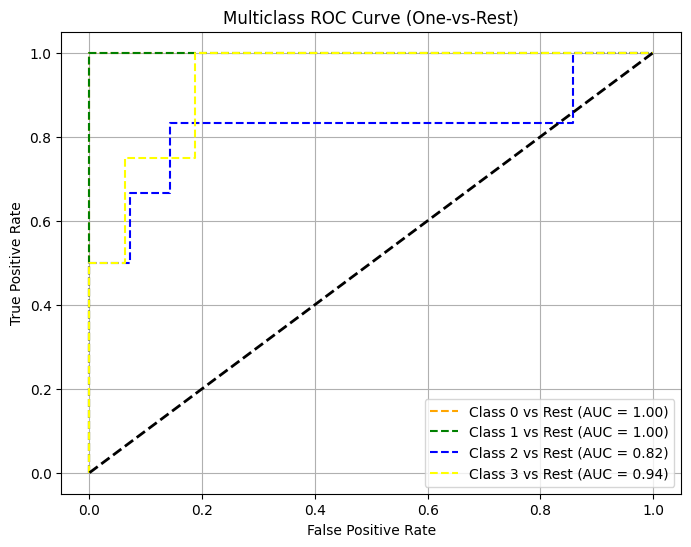

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Dictionnaires pour stocker les résultats
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}
n_class = 4  # le nombre de classes

# Calcul FPR, TPR, Thresholds et AUC pour chaque classe
for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])

# --- Tracer les courbes ROC avec AUC dans la légende ---
plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'blue', 'yellow', 'red']
for i, color in zip(range(n_class), colors):
    plt.plot(fpr[i], tpr[i], linestyle='--', color=color,
             label=f'Class {i} vs Rest (AUC = {roc_auc[i]:.2f})')

# --- Tracer la diagonale aléatoire ---
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# --- Réglages du plot ---
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('Multiclass_ROC.png', dpi=300)
plt.show()
